In [1]:
!date

Fri Feb 28 13:14:50 PST 2020


# Validating with 10x TCC

In [1]:
import anndata
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy import stats
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
import ast
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
path = "/home/sina/projects/mop/mop_10xv3"
file_paths = glob.glob(path + "/tcc_gene_out*/counts_filtered/adata.h5ad")

In [3]:
file_paths = np.sort(file_paths).tolist()

In [4]:
adata = anndata.read_h5ad(file_paths[0])

In [30]:
ss_adata = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 8014 × 2646642 
    var: 'transcript_ids'

In [7]:
adata.var["transcript_ids"] = adata.var["transcript_ids"].apply(lambda x: ast.literal_eval(x))
adata.var["ec_len"] = adata.var["transcript_ids"].apply(lambda x: len(x))

unique = adata[:,adata.var["ec_len"]==1].var["transcript_ids"].apply(lambda x: x[0])
nu_ecs = adata[:,adata.var["ec_len"]>1].var["transcript_ids"].explode().unique()

adata = adata[:,adata.var.ec_len==1]
adata.var["transcript_id"] = adata.var.transcript_ids.apply(lambda x: x[0])

adata.var["transcript_id_nov"] = adata.var["transcript_id"].str.slice(0,18)
adata = adata[:,adata.var["transcript_id_nov"].isin(ss.var.transcript_id)]

Trying to set attribute `.var` of view, copying.


In [8]:
adata.layers["X"] = adata.X

In [9]:
from sklearn.preprocessing import normalize

In [10]:
mtx = normalize(adata.X, norm='l1', axis=1)

In [11]:
scale = 1000000
adata.X = mtx*scale
adata.layers["log1p"] = np.log1p(mtx*scale)

In [12]:
scanp.pp.log1p(adata)

In [13]:
adata.X

<8014x84364 sparse matrix of type '<class 'numpy.float64'>'
	with 29365151 stored elements in Compressed Sparse Row format>

## Highly variable genes

In [14]:
adata

AnnData object with n_obs × n_vars = 8014 × 84364 
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [15]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 0.5e6
disp_threshold = 10

mito_criteria = 50

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [16]:
scanp.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = adata.var.highly_variable.values

In [17]:
scanp.pp.scale(adata, max_value=scale_clip)

# Finding the isoforms that are relevant

In [18]:
%%time
#u = np.setdiff1d(np.sort(unique),np.sort(nu_ecs))

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs


In [19]:
#u

In [391]:
#tenx = adata[:,adata.var.transcript_id.isin(u)]

In [20]:
adata.obs.index = adata.obs.index + "-3L8TX_181211_01_A01"

In [21]:
ca = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.annotation.csv", index_col=0)
cm = pd.read_csv("/home/sina/projects/mop/mop_10xv3/dropbox/cluster.membership.csv", index_col=0)

In [22]:
adata = adata[adata.obs.index.isin(cm.index)]

In [23]:
adata.obs["cluster_id"] = adata.obs.index.map(cm["x"])

Trying to set attribute `.obs` of view, copying.


In [24]:
adata.obs["cluster_label"]  = adata.obs["cluster_id"].map(ca["cluster_label"])
adata.obs["subclass_label"] = adata.obs["cluster_id"].map(ca["subclass_label"])
adata.obs["class_label"]    = adata.obs["cluster_id"].map(ca["class_label"])

In [25]:
le = LabelEncoder()
adata.obs["cluster_id"] = le.fit_transform(adata.obs.cluster_label.values)

le = LabelEncoder()
adata.obs["subclass_id"] = le.fit_transform(adata.obs.subclass_label.values)

le = LabelEncoder()
adata.obs["class_id"] = le.fit_transform(adata.obs.class_label.values)

In [26]:
adata

AnnData object with n_obs × n_vars = 6355 × 84364 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [27]:
#common_isoforms = np.intersect1d(ss.var.transcript_id.values, tenx.var.transcript_id_nov.values)

In [28]:
#common_isoforms.shape

In [73]:
# tenx = tenx[:,tenx.var.transcript_id_nov.isin(common_isoforms)]
# ss = ss[:,ss.var.transcript_id.isin(common_isoforms)]

In [74]:
tenx = adata
ss = ss_adata

ss = ss[:,ss.var.sort_values("transcript_id").index]
tenx = tenx[:,tenx.var.sort_values("transcript_id").index]

In [32]:
def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [34]:
mask = np.asarray((tenx.layers["X"]>0).sum(axis=0)>1000).reshape(-1)

In [35]:
tenx = tenx[:,mask]
ss = ss[:,mask]

In [36]:
ss

View of AnnData object with n_obs × n_vars = 6043 × 7117 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [37]:
tenx

View of AnnData object with n_obs × n_vars = 6355 × 7117 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [348]:
%%time

mtx           = ss.X
components    = ss.obs.cell_id.values
features   = ss.var.transcript_id.values

s2t = ss.obs

# Data for gene matrix
X1, c1, f1 = group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components")

CPU times: user 52.5 ms, sys: 2.64 ms, total: 55.2 ms
Wall time: 53.8 ms


In [349]:
tenx

View of AnnData object with n_obs × n_vars = 6355 × 513 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'cell_id'
    var: 'transcript_ids', 'ec_len', 'transcript_id', 'transcript_id_nov', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'X', 'log1p'

In [350]:
tenx.obs["cell_id"] = tenx.obs.index.values

Trying to set attribute `.obs` of view, copying.


In [351]:
%%time

mtx           = tenx.X
components    = tenx.obs.cell_id.values
features   = tenx.var.transcript_id_nov.values

s2t = tenx.obs

# Data for gene matrix
X2, c2, f2 = group_mtx_by_cluster(mtx, components, features, s2t, source_id="cell_id", target_id="subclass_label", by="components")

CPU times: user 12.7 ms, sys: 2.69 ms, total: 15.3 ms
Wall time: 13.7 ms


In [352]:
common_clusters = np.intersect1d(f1, f2)

In [353]:
common_clusters

array(['L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT',
       'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Sncg', 'Sst', 'Vip'],
      dtype='<U11')

In [354]:
%%time
r2 = []
for cidx, c in enumerate(common_clusters):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]
    r, p = stats.pearsonr(x, y)
    r2.append(r**2)

CPU times: user 6.53 ms, sys: 450 µs, total: 6.98 ms
Wall time: 5.29 ms


In [355]:
r2

[0.062251691350837295,
 0.28956170878529214,
 0.12592115286699654,
 0.4759677882467309,
 0.20331831296311842,
 0.09537499062252953,
 0.052156342262652484,
 0.5480761494424008,
 0.5082358752768769,
 0.21867271392051774,
 0.3935792911652108,
 0.6011198920702236,
 0.436020580132773]

In [57]:
cluster_cmap = {
"Astro" : (0.9019607843137255,  0.3333333333333333,  0.050980392156862744),  # e6550d #reds
"Endo" : (0.9921568627450981,  0.5529411764705883,  0.23529411764705882 ),  # fd8d3c
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP" : (0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6 IT Car3" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6b" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Low Quality" : (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
"SMC" : (0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
"VLMC" : (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
# (0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
#"Pvalb" : (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  ),  # 756bb1
#(0.6196078431372549,  0.6039215686274509,  0.7843137254901961  ),  # 9e9ac8
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
#"Pvalb":(0.8549019607843137,  0.8549019607843137,  0.9215686274509803  ),  # dadaeb
}

In [357]:
ss_size = ss.obs["subclass_label"].value_counts()[common_clusters]

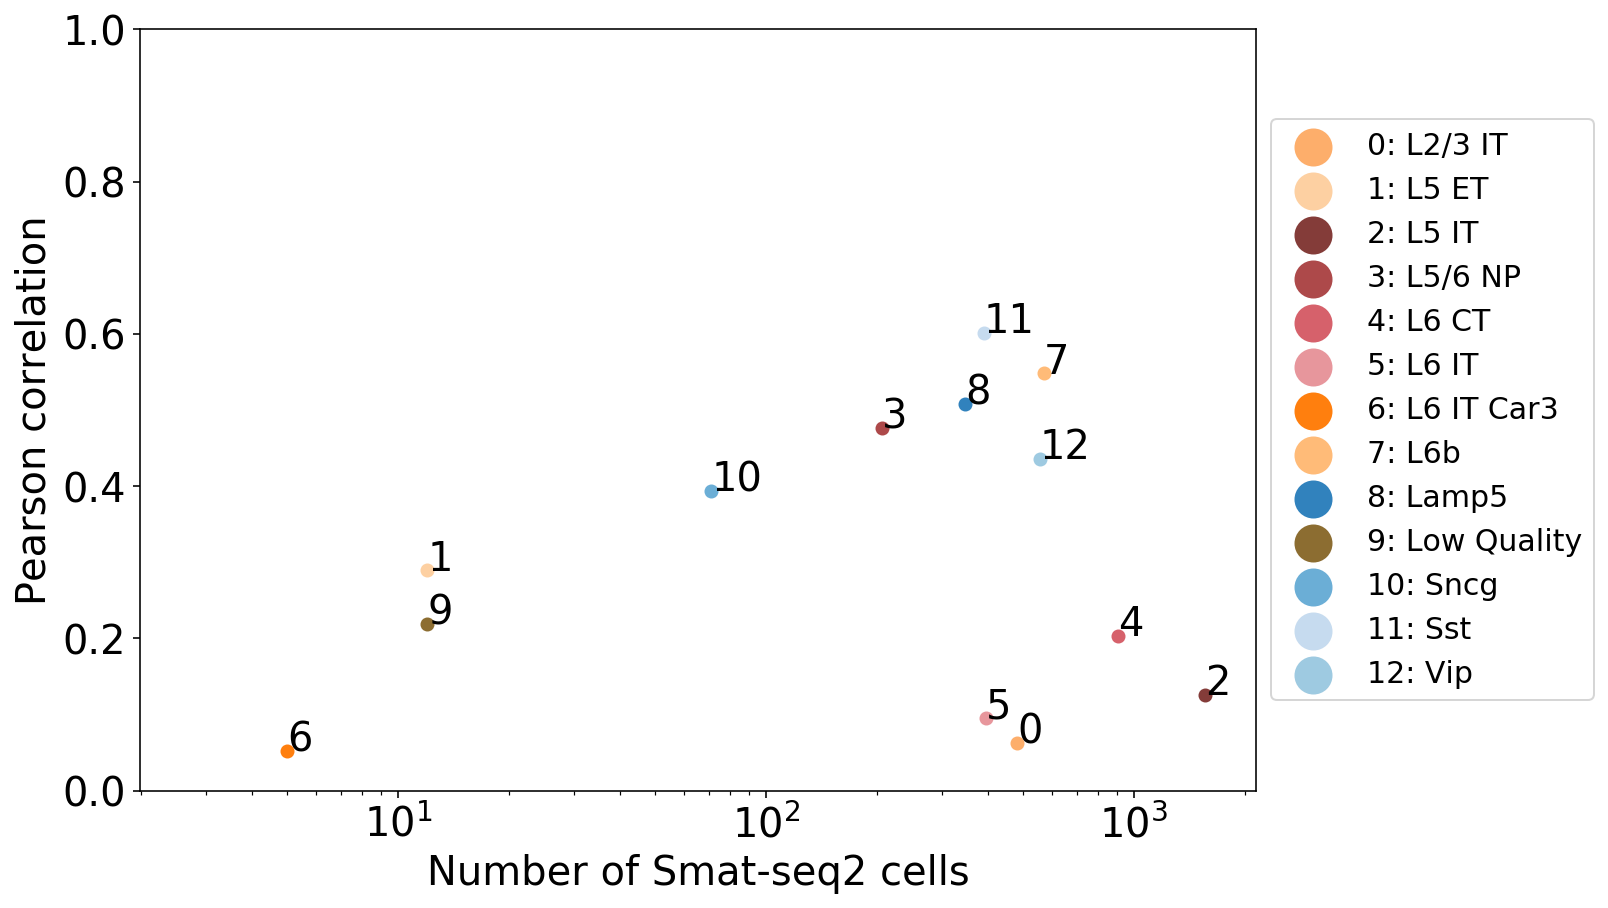

In [358]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(common_clusters):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smat-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
#plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [248]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

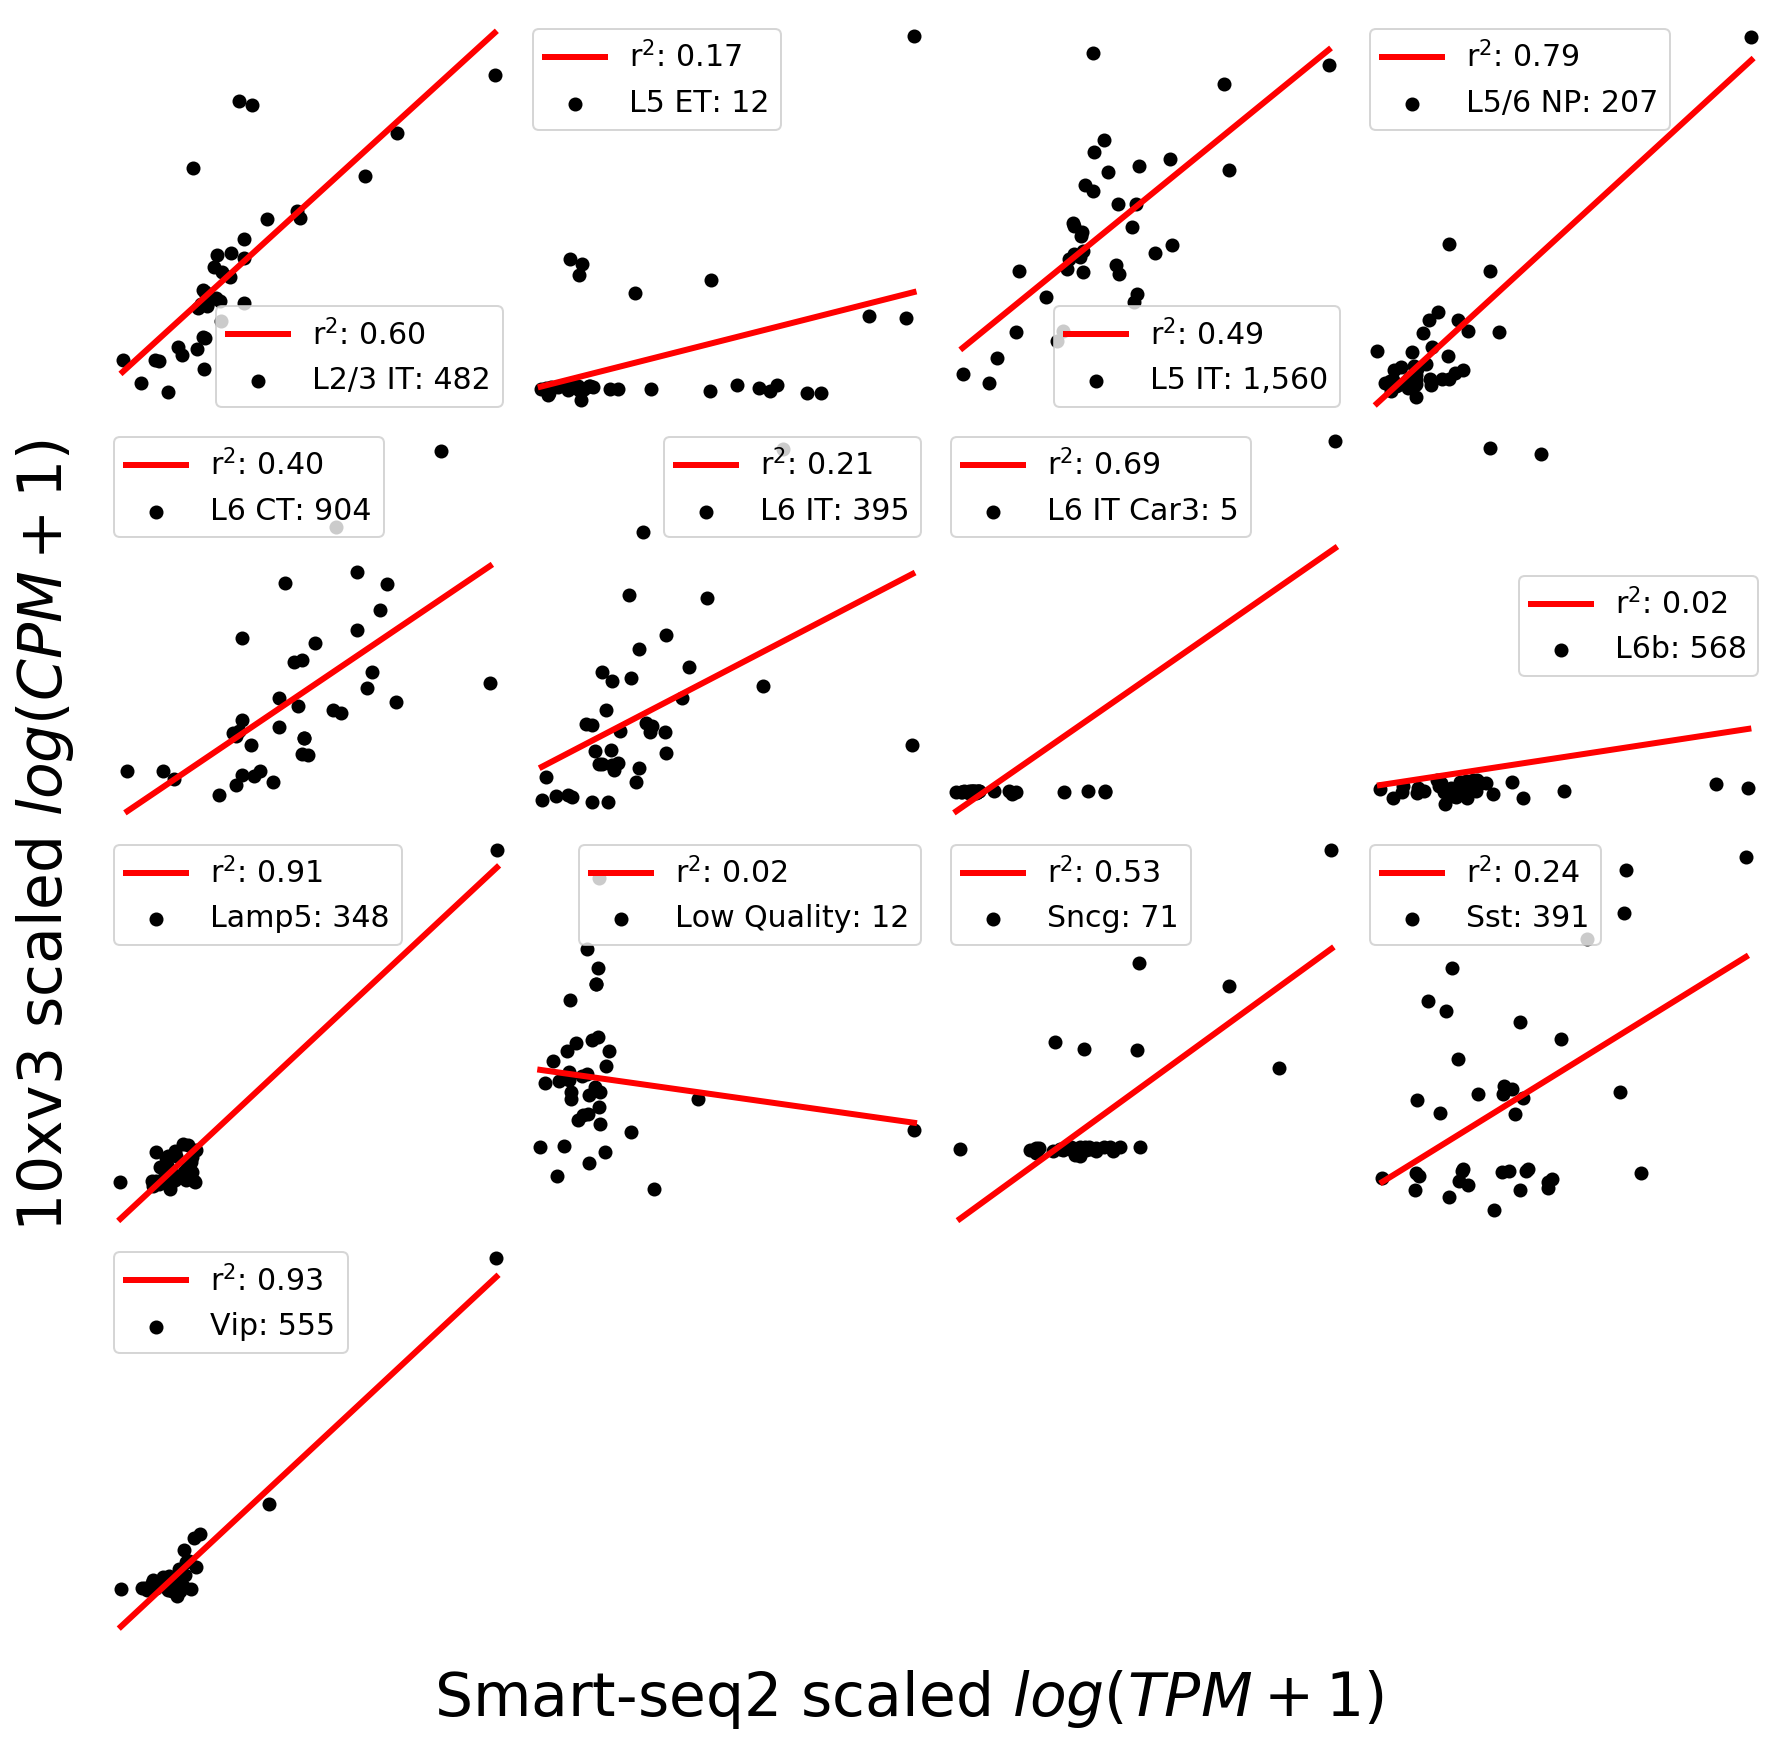

In [249]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(common_clusters))

for cidx, (ax, c) in enumerate(zip(axs, common_clusters)):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k")

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
#plt.savefig("./additional_figs/10x_correlation.png", bbox_inches='tight',dpi=300)

plt.show()

# Performing analysis celltype by celltype

For each cluster we want a list of 200 isoforms that are the most highly expressed from 10x

In [264]:
tenx_mat = tenx.X
tenx_ass = tenx.obs.subclass_label.values

ss_mat = ss.X
ss_ass = ss.obs.subclass_label.values

features = tenx.var.transcript_id_nov.values

unique = np.intersect1d(np.unique(tenx_ass), np.unique(ss_ass))

In [266]:
def nd(arr):
    return np.asarray(arr).reshape(-1)

In [280]:
mat = tenx.layers["X"]

#n=500
threshold = 5
frac = 0.9

lower = 0.5
upper = 0.6

#threshold=0.9

bool_mask = np.zeros((unique.shape[0], features.shape[0]), dtype=bool)

for uidx, u in enumerate(unique):
    print("{} of {}: {}".format(uidx+1, unique.shape[0], u))
    t_mat, _ = split_by_target(mat, tenx_ass, u)

    numc = t_mat.shape[0]
    numnz = (t_mat>0).sum(axis=0)

    arr = np.logical_and(nd(numnz>lower*numc), nd(numnz<upper*numc))
    
    #arr = np.logical_and(np.array(t_mat.mean(axis=0)>threshold).reshape(-1), (np.array((t_mat>0).sum(axis=0)>t_mat.shape[0]*frac).reshape(-1)))
    print(arr.sum())
    
    #argnmax = arr.argsort()[-n:][::-1]

    bool_mask[uidx,:][arr] = True

1 of 13: L2/3 IT
768
2 of 13: L5 ET
383
3 of 13: L5 IT
687
4 of 13: L5/6 NP
574
5 of 13: L6 CT
709
6 of 13: L6 IT
712
7 of 13: L6 IT Car3
0
8 of 13: L6b
0
9 of 13: Lamp5
682
10 of 13: Low Quality
215
11 of 13: Sncg
543
12 of 13: Sst
643
13 of 13: Vip
475


In [274]:
bool_mask.sum(axis=1)

array([1738, 1245, 1545, 1393, 1557, 1655,    0, 1131, 1530,  577, 1224,
       1444, 1241])

In [281]:
%%time
r2 = []
ss_x = []
tenx_x = []
for uidx, u in enumerate(unique):
    r = 0
    if u != "L6 IT Car3" or u!="L6b":
        print("{}: {} of {}".format(u, uidx+1, unique.shape[0]))
        tenx_t_mat, _ = split_by_target(tenx_mat, tenx_ass, u)
        ss_t_mat, _ = split_by_target(ss_mat, ss_ass, u)
        
        
        t = np.asarray(tenx_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
        s = np.asarray(ss_t_mat[:,bool_mask[uidx]].mean(axis=0)).reshape(-1)
    
        ss_x.append(s)
        tenx_x.append(t)
        
        r, p = stats.pearsonr(t, s)
    r2.append(r**2)

L2/3 IT: 1 of 13
L5 ET: 2 of 13
L5 IT: 3 of 13
L5/6 NP: 4 of 13
L6 CT: 5 of 13
L6 IT: 6 of 13
L6 IT Car3: 7 of 13


ValueError: x and y must have length at least 2.

In [276]:
r2

[0.49995936823696774,
 0.22145452591416848,
 0.33455340743222606,
 0.6311280723503694,
 0.4653661882238531,
 0.5480786606190731,
 0,
 0.15793456772200726,
 0.7366985211799746,
 0.35639957487123325,
 0.5406602000755094,
 0.6279970765613323,
 0.7091570497686646]

In [277]:
ss_size = ss.obs["subclass_label"].value_counts()[unique]

In [278]:
tenx.obs["subclass_label"].value_counts()

L5 IT          2180
Low Quality    1829
L2/3 IT         796
L6 CT           572
Vip             232
Lamp5           225
L6 IT           202
L5/6 NP         186
Sst              75
L5 ET            18
Sncg             13
Oligo            11
L6b               8
doublet           6
L6 IT Car3        1
Macrophage        1
Name: subclass_label, dtype: int64

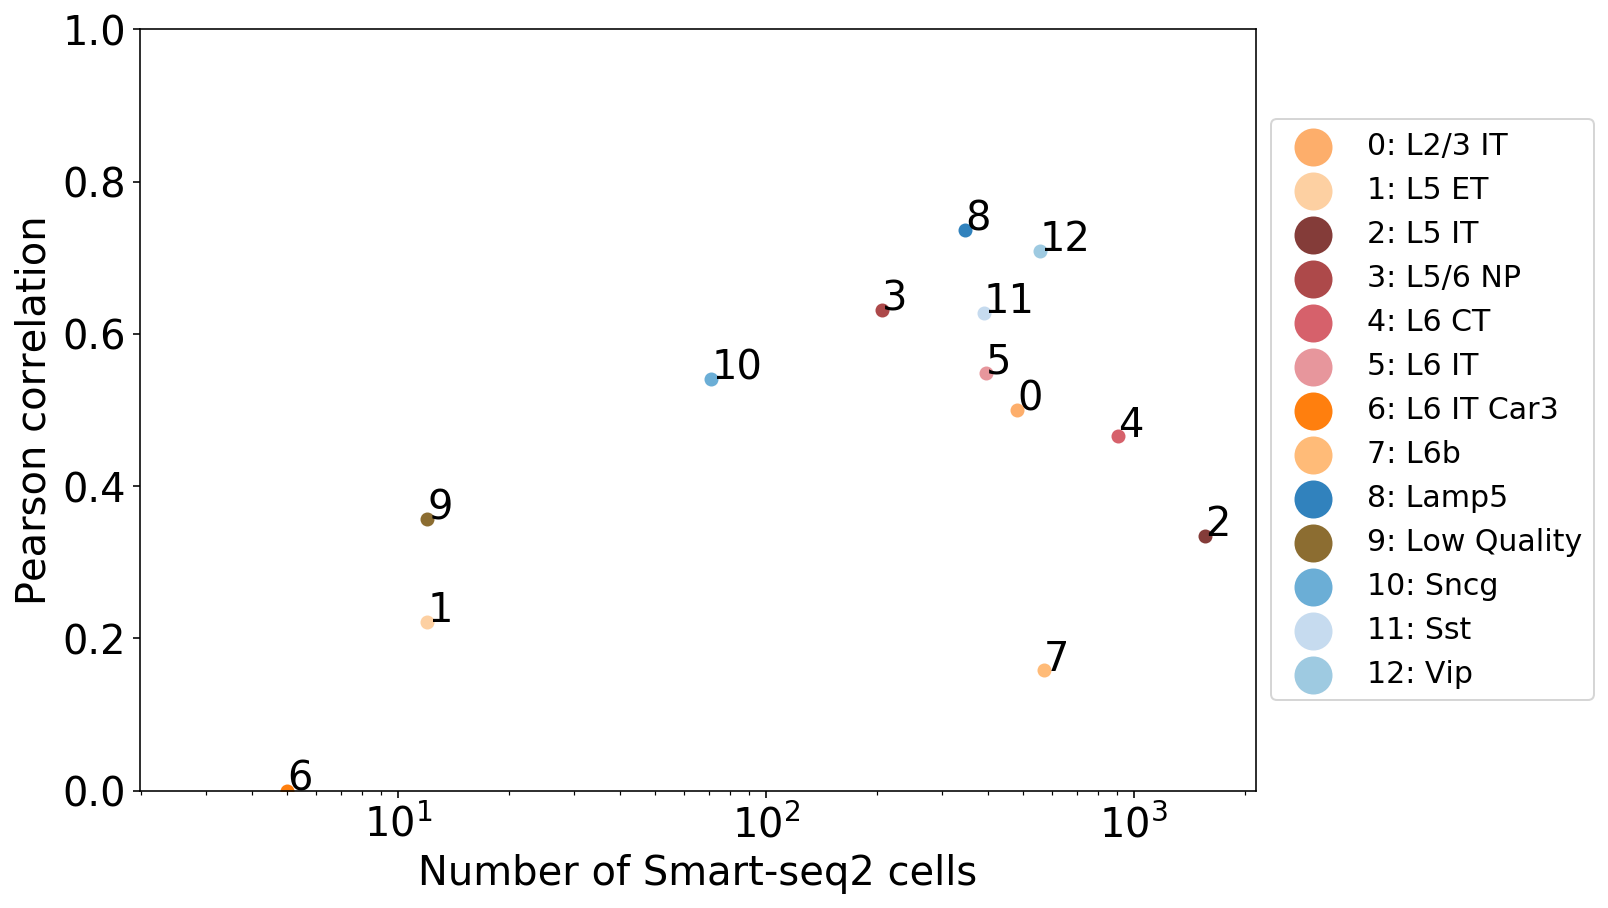

In [279]:
fig, ax = plt.subplots(figsize=(10,7))

x = ss_size
y = r2

for i, txt in enumerate(unique):
    ax.annotate(i, (x[i], y[i]))
    ax.scatter(x[i], y[i], label="{}: {}".format(i, txt), color=cluster_cmap[txt])
ax.set_ylim((0, 1))
ax.set_xscale("log")
    
ax.set_xlabel("Number of Smart-seq2 cells")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.5), markerscale=3)
#plt.savefig("./level_1_fig/10_correlation.png", bbox_inches='tight', dpi=300)
plt.show()

In [246]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

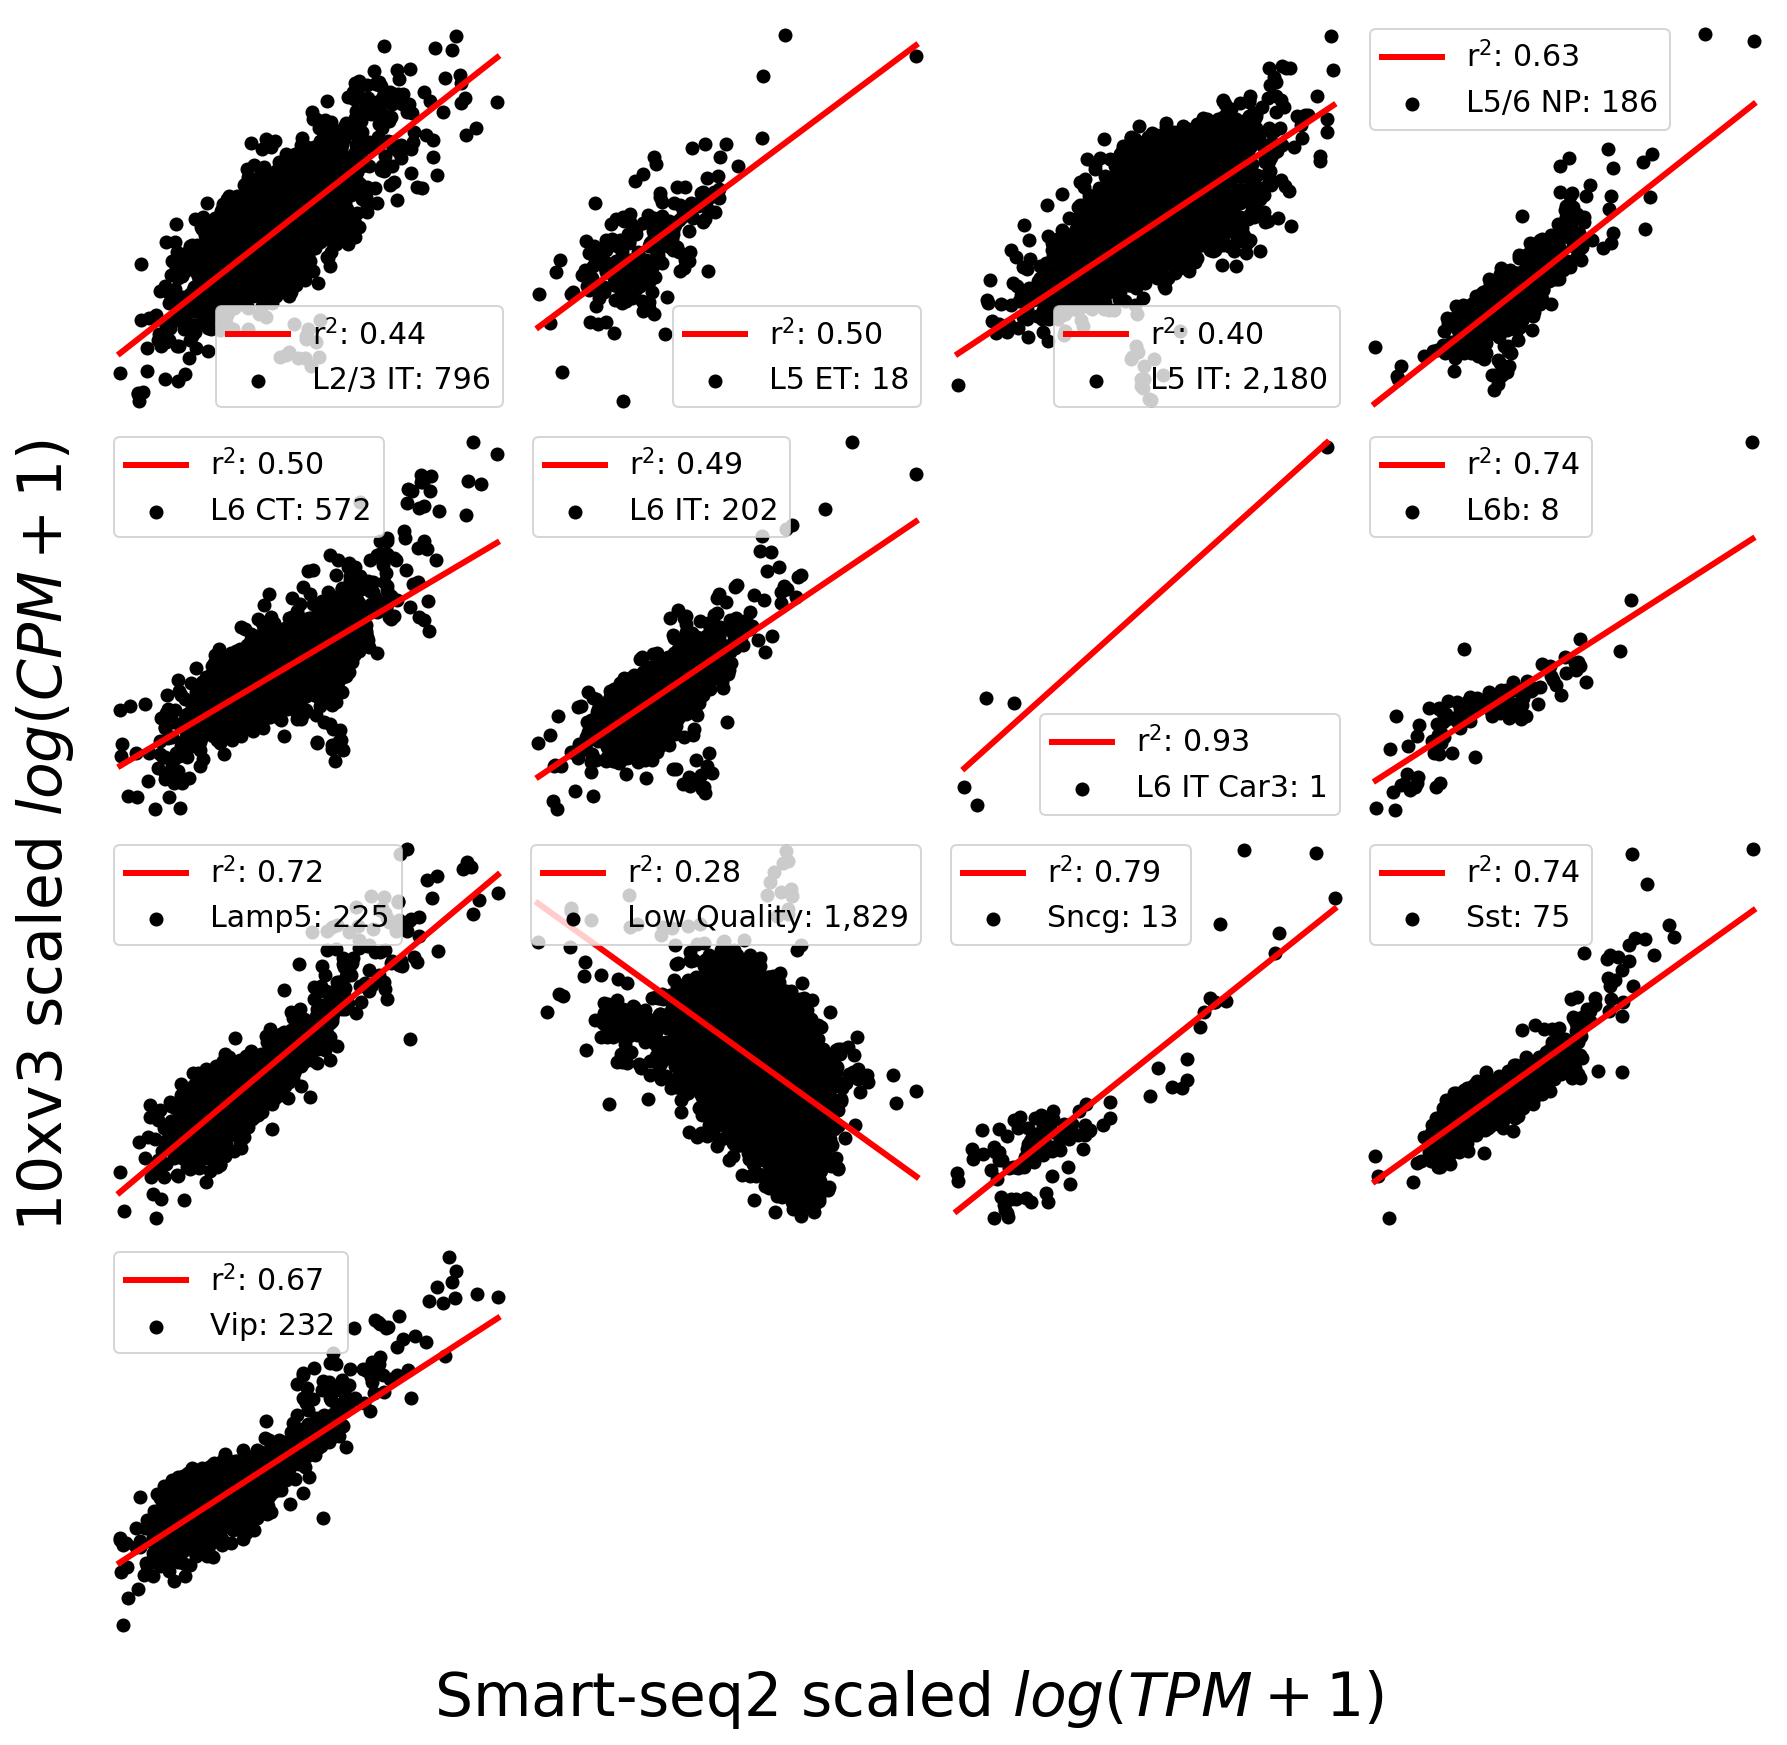

In [251]:
fig, ax = plt.subplots(figsize=(15,15), ncols=4, nrows=4)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(unique))

for cidx, (ax, c) in enumerate(zip(axs, unique)):
    
    
    x = ss_x[cidx]
    y = tenx_x[cidx]

    
    ax.scatter(x, y, label="{}: {:,}".format(c, ss_size[cidx]), color="k")

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    minx = min(x)
    maxx = max(x)
    x = np.linspace(minx, maxx, 10)
    y = slope*x+intercept
    ax.plot(x, y, label="r$^2$: {:,.2f}".format(r_value**2), color="red", linewidth=3)
    ax.legend(fontsize=15)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
fig.text(0.5, 0.1, 'Smart-seq2 scaled $log(TPM+1)$', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, '10xv3 scaled $log(CPM+1)$', ha='center', va='center', rotation='vertical', fontsize=30)
#plt.savefig("./additional_figs/10x_correlation.png", bbox_inches='tight',dpi=300)

plt.show()

In [259]:
features[bool_mask[1]]

array(['ENSMUST00000000137', 'ENSMUST00000000199', 'ENSMUST00000002412',
       'ENSMUST00000003501', 'ENSMUST00000006027', 'ENSMUST00000006235',
       'ENSMUST00000006435', 'ENSMUST00000006991', 'ENSMUST00000007012',
       'ENSMUST00000008036', 'ENSMUST00000009727', 'ENSMUST00000011896',
       'ENSMUST00000013807', 'ENSMUST00000015146', 'ENSMUST00000017637',
       'ENSMUST00000018470', 'ENSMUST00000019109', 'ENSMUST00000019514',
       'ENSMUST00000020027', 'ENSMUST00000020081', 'ENSMUST00000020107',
       'ENSMUST00000020287', 'ENSMUST00000020488', 'ENSMUST00000020537',
       'ENSMUST00000020706', 'ENSMUST00000020896', 'ENSMUST00000020904',
       'ENSMUST00000021273', 'ENSMUST00000022629', 'ENSMUST00000022639',
       'ENSMUST00000022894', 'ENSMUST00000023225', 'ENSMUST00000023507',
       'ENSMUST00000024739', 'ENSMUST00000025110', 'ENSMUST00000025290',
       'ENSMUST00000025356', 'ENSMUST00000025541', 'ENSMUST00000025563',
       'ENSMUST00000026196', 'ENSMUST00000026985', 

In [263]:
ss.var[ss.var.gene_name == "Actr2"]

,transcript_id,gene_id,gene_name,transcript_name,gene_TPM,highly_variable,means,dispersions,dispersions_norm
Actr2-201,ENSMUST00000000137,ENSMUSG00000020152,Actr2,Actr2-201,1.144473e+06,False,5.241097,4.443319,-0.817120
Actr2-202,ENSMUST00000132022,ENSMUSG00000020152,Actr2,Actr2-202,7.467234e+04,False,2.581959,4.463260,0.367289
Actr2-203,ENSMUST00000134779,ENSMUSG00000020152,Actr2,Actr2-203,5.863056e+04,False,2.360423,3.425874,-0.950343
